In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Questão 1

In [39]:
def exact_solution(x, t, delta=2.0):
    """Solução exata dada no enunciado."""
    return 0.5 * (1.0 - np.tanh((x - 2.0 * t / delta) / delta))

def initial_phi(x, delta=2.0):
    """Condição inicial φ(x) = 1/2 (1 - tanh(x/2))."""
    return 0.5 * (1.0 - np.tanh(x / 2.0))

def tridiag_solve(a, b, c, d):
    """Algoritmo de Thomas para sistemas tridiagonais."""
    n = len(b)
    ac, bc, cc, dc = a.copy(), b.copy(), c.copy(), d.copy()

    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]

    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]

    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]

    return x

In [40]:
def solve_back_euler_delayed(a, b, T, N_elements, delta=2.0, dt=None):
    Nel = N_elements
    J = Nel + 1
    h = (b - a) / Nel
    x = np.linspace(a, b, J)

    if dt is None:
        dt = h
    num_steps = int(np.ceil(T / dt))
    dt = T / num_steps

    alpha = 1.0
    beta = 0.0

    u = initial_phi(x, delta=delta)

    n = J - 2
    coef_off = -1.0 / h**2
    coef_main = 1.0 / dt + 2.0 / h**2

    a_sub = np.full(n-1, coef_off)
    b_main = np.full(n, coef_main)
    c_sup = np.full(n-1, coef_off)

    for _ in range(num_steps):
        u_nl = (8.0 / delta**2) * (u[1:-1]**2) * (1.0 - u[1:-1])
        rhs = u[1:-1] / dt + u_nl

        rhs[0] -= coef_off * alpha
        rhs[-1] -= coef_off * beta

        u_int = tridiag_solve(a_sub, b_main, c_sup, rhs)

        u = np.zeros_like(u)
        u[0] = alpha
        u[1:-1] = u_int
        u[-1] = beta

    return x, u, h, dt, num_steps

In [41]:
def plot_comparison_at_T(N_list_plot, a, b, T, delta):
    for N in N_list_plot:
        print(f"Executando N={N} ...")
        x, u_num, h, dt, _ = solve_back_euler_delayed(a, b, T, N, delta=delta)
        u_ex = exact_solution(x, T, delta)

        plt.figure(figsize=(8,5))
        plt.plot(x, u_ex, label="Solução exata", linewidth=2)
        plt.plot(x, u_num, '--', label=f"Aproximada (N={N}, h={h:.4f})")
        plt.xlabel("x")
        plt.ylabel("u(x,T)")
        plt.title(f"Comparação Exata × Aproximada — N={N}")
        plt.legend()
        plt.grid(True)
        plt.show()

In [42]:
def calculate_convergence_rate(h_list, errors):
    """
    p ≈ log(erro) / log(h)
    """
    coeffs = np.polyfit(np.log(h_list), np.log(errors), 1)
    p = coeffs[0]
    return p

def convergence_study(N_list, a, b, T, delta, dt_mode='h'):
    h_list = []
    errors = []

    for N in N_list:
        h = (b - a) / N
        dt = h if dt_mode == 'h' else h**2

        x, u_num, _, _, _ = solve_back_euler_delayed(a, b, T, N, delta=delta, dt=dt)
        u_ex = exact_solution(x, T, delta)

        err_inf = np.max(np.abs(u_num - u_ex))

        h_list.append(h)
        errors.append(err_inf)

        print(f"N={N:4d}, h={h:.2e}, dt={dt:.2e} => Erro Inf = {err_inf:.4e}")

    return np.array(h_list), np.array(errors)

def plot_convergence_combined(h_h, err_h, h_h2, err_h2):

    p_h = calculate_convergence_rate(h_h, err_h)
    p_h2 = calculate_convergence_rate(h_h2, err_h2)

    plt.figure(figsize=(10, 7))

    plt.loglog(h_h, err_h, 'o-', linewidth=2, markersize=6,
               label=f"dt = h (Taxa $p \\approx {p_h:.2f}$)")

    plt.loglog(h_h2, err_h2, 's-', linewidth=2, markersize=6,
               label=f"dt = $h^2$ (Taxa $p \\approx {p_h2:.2f}$)")

    
    ref_h1 = h_h
    ref_err1 = ref_h1 * (err_h[0] / ref_h1[0]) 
    plt.loglog(ref_h1, ref_err1, 'k:', alpha=0.5, label="Ref. Ordem 1 ($O(h)$)")

    ref_h2 = h_h2
    ref_err2 = ref_h2**2 * (err_h2[0] / ref_h2[0]**2) 
    plt.loglog(ref_h2, ref_err2, 'k-.', alpha=0.5, label="Ref. Ordem 2 ($O(h^2)$)")

    plt.xlabel("Passo espacial $h$ (log scale)", fontsize=12)
    plt.ylabel("Erro Global $||E||_{\\infty}$ (log scale)", fontsize=12)
    plt.title("Estudo de Convergência: Método Implícito", fontsize=14)
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


In [43]:
def print_error_table(N_list, h_list, errors, title):
    print("\n=========================================")
    print(f"Tabela de erros — {title}")
    print("=========================================")
    print(f"{'N':>8} | {'h':>12} | {'erro_inf':>12}")
    print("-----------------------------------------")
    for N, h, e in zip(N_list, h_list, errors):
        print(f"{N:8d} | {h:12.6e} | {e:12.6e}")
    print("=========================================\n")

Executando N=75 ...


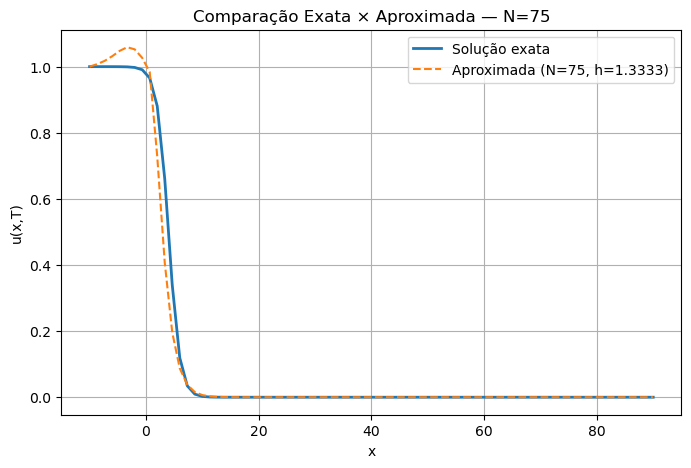

Executando N=150 ...


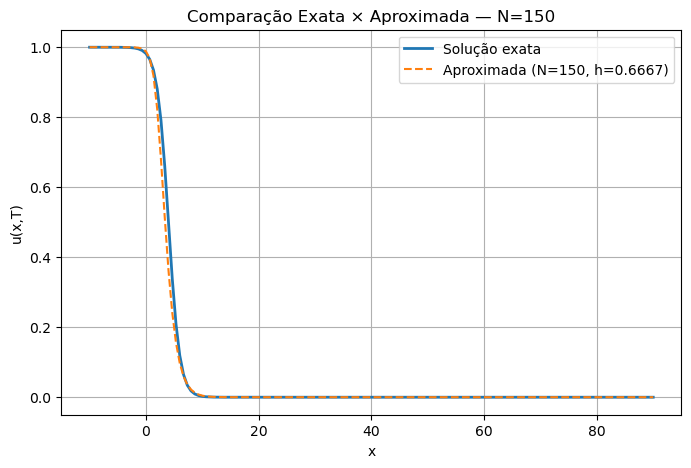

Executando N=500 ...


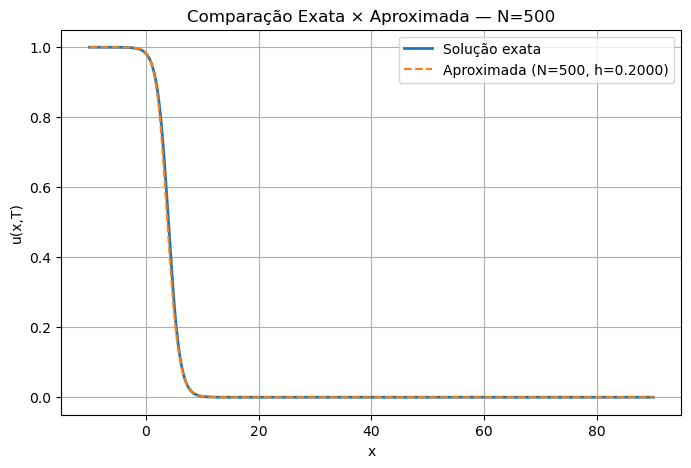


==== Estudo: dt = h ====
N= 500, h=2.00e-01, dt=2.00e-01 => Erro Inf = 5.0055e-02
N=1000, h=1.00e-01, dt=1.00e-01 => Erro Inf = 2.5693e-02
N=2000, h=5.00e-02, dt=5.00e-02 => Erro Inf = 1.3015e-02
N=4000, h=2.50e-02, dt=2.50e-02 => Erro Inf = 6.5512e-03
N=8000, h=1.25e-02, dt=1.25e-02 => Erro Inf = 3.2864e-03

==== Estudo: dt = h² ====
N= 500, h=2.00e-01, dt=4.00e-02 => Erro Inf = 1.0958e-02
N=1000, h=1.00e-01, dt=1.00e-02 => Erro Inf = 2.7656e-03
N=2000, h=5.00e-02, dt=2.50e-03 => Erro Inf = 6.9298e-04
N=4000, h=2.50e-02, dt=6.25e-04 => Erro Inf = 1.7334e-04
N=8000, h=1.25e-02, dt=1.56e-04 => Erro Inf = 4.3342e-05


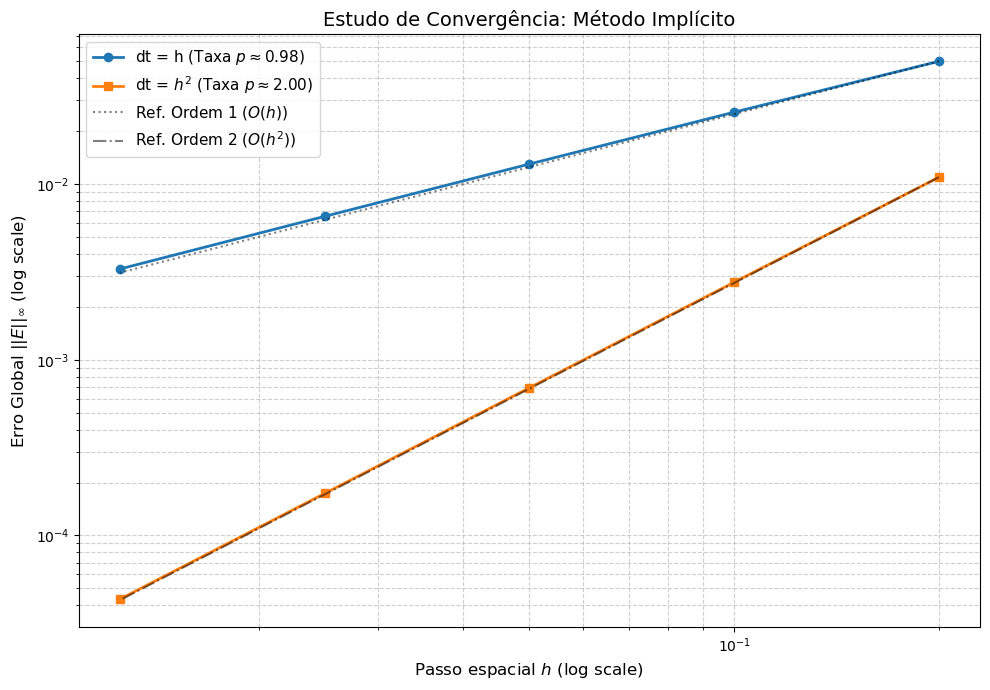


Tabela de erros — dt = h
       N |            h |     erro_inf
-----------------------------------------
     500 | 2.000000e-01 | 5.005529e-02
    1000 | 1.000000e-01 | 2.569322e-02
    2000 | 5.000000e-02 | 1.301506e-02
    4000 | 2.500000e-02 | 6.551178e-03
    8000 | 1.250000e-02 | 3.286412e-03


Tabela de erros — dt = h²
       N |            h |     erro_inf
-----------------------------------------
     500 | 2.000000e-01 | 1.095845e-02
    1000 | 1.000000e-01 | 2.765611e-03
    2000 | 5.000000e-02 | 6.929775e-04
    4000 | 2.500000e-02 | 1.733420e-04
    8000 | 1.250000e-02 | 4.334159e-05



In [44]:
#  EXECUÇÃO PRINCIPAL

a = -10.0
b = 90.0
T = 4.0
delta = 2.0

# (b) Gráficos comparativos
N_plot = [75, 150, 500]
plot_comparison_at_T(N_plot, a, b, T, delta)

# (c) Estudo de convergência
N_list = [500, 1000, 2000, 4000, 8000]

print("\n==== Estudo: dt = h ====") 
h_vec_h, err_vec_h = convergence_study(N_list, a, b, T, delta, dt_mode='h')

print("\n==== Estudo: dt = h² ====") 
h_vec_h2, err_vec_h2 = convergence_study(N_list, a, b, T, delta, dt_mode='h2')

plot_convergence_combined(h_vec_h, err_vec_h, h_vec_h2, err_vec_h2)

# Tabelas
print_error_table(N_list, h_vec_h, err_vec_h, "dt = h")
print_error_table(N_list, h_vec_h2, err_vec_h2, "dt = h²")

# Questão 2

In [ ]:
def f(u, delta=2.0):
    """
    Termo reativo f(u) = (8/delta^2) * u^2 * (1 - u)
    """
    return (8.0 / delta**2) * (u**2) * (1.0 - u)

def CN_step(u_star, dt, h, alpha=1.0, beta=0.0):
    """
    Aplica Crank-Nicolson (Problema B) ao vetor u_star (inclui condições de contorno nas posições 0 e -1).
    Resolve o sistema tridiagonal (matriz (I - sigma/2 * L)) com RHS = (I + sigma/2 * L) u_star.
    """
    J = len(u_star)              # número de nós (J = Nel + 1)
    u_prev_int = u_star[1:-1]    # vetor com nós internos (u_star_j)
    n = len(u_prev_int)
    if n == 0:
        return u_star.copy()

    sigma = dt / (h**2)

    a = np.full(n-1, -sigma/2.0)   # sub-diagonal (a_1 ... a_{n-1})
    b = np.full(n, 1.0 + sigma)    # diagonal principal
    c = np.full(n-1, -sigma/2.0)   # super-diagonal

    rhs = (1.0 - sigma) * u_prev_int.copy()
    rhs += (sigma/2.0) * (u_star[2:] + u_star[:-2])

    # O termo da matriz esquerda que multiplicaria u^{n+1}_0 e u^{n+1}_J é movido para o RHS:
    rhs[0]   -= a[0] * alpha    # primeiro interno depende de u^{n+1}_0 = alpha
    rhs[-1]  -= c[-1] * beta    # último interno depende de u^{n+1}_J = beta

    # resolver sistema tridiagonal (Thomas)
    u_next_int = tridiag_solve(a, b, c, rhs)

    u_next = np.zeros_like(u_star)
    u_next[0] = alpha
    u_next[1:-1] = u_next_int
    u_next[-1] = beta

    return u_next

In [48]:
# Função principal: resolve Problema A (explícito) e Problema B (CN implícito) alternadamente
def solve_problemaA_problemaB(a, b, T, Nel, delta=2.0, dt=None):
    """
    Resolve o problema usando splitting sequencial (Lie splitting):
    - Problema A (explícito): u_t = f(u)  (forward Euler)
    - Problema B (implícito CN): u_t = u_xx (Crank-Nicolson)
    """
    Nel = int(Nel)
    J = Nel + 1
    h = (b - a) / Nel
    x = np.linspace(a, b, J)

    if dt is None:
        dt = h
    num_steps = int(np.ceil(T / dt))
    dt = T / num_steps    # ajusta dt para dividir exatamente T

    # Condições de contorno 
    alpha = 1.0   # u(a,t) = 1
    beta = 0.0    # u(b,t) = 0

    # condição inicial u^0
    u_prev = initial_phi(x, delta=delta)  # u^n no início

    # laço temporal: para cada n, aplicar A (explícito) então B (CN)
    for nstep in range(num_steps):
        # u_star_j = u_j^n + dt * f(u_j^n)
        u_star = u_prev.copy()
        # aplica somente nos nós internos; 
        u_star[1:-1] = u_prev[1:-1] + dt * f(u_prev[1:-1], delta=delta)
        u_star[0] = alpha
        u_star[-1] = beta

        # Crank-Nicolson para difusão
        u_next = CN_step(u_star, dt, h, alpha=alpha, beta=beta)

        u_prev = u_next

    return x, u_next, h, dt, num_steps

In [49]:
def plot_solucao_exata_vs_aproximada(N_list_plot, a, b, T, delta):
    for Nel in N_list_plot:
        print(f"Executando solve_problemaA_problemaB com Nel = {Nel} ...")
        x, u_num, h, dt, _ = solve_problemaA_problemaB(a, b, T, Nel, delta=delta)
        u_ex = exact_solution(x, T, delta)

        plt.figure(figsize=(8,5))
        plt.plot(x, u_ex, label="Solução exata", linewidth=2)
        plt.plot(x, u_num, '--', label=f"Aproximada (Nel={Nel}, h={h:.4e})")
        plt.xlabel("x")
        plt.ylabel("u(x,T)")
        plt.title(f"Solução exata vs Aproximada — Nel={Nel}")
        plt.legend()
        plt.grid(True)
        plt.show()

def convergence_study_problemaAB(N_list, a, b, T, delta):
    """
    Estudo de convergência na norma do máximo para o método do Problema A+B.
    Usa Δt = h conforme item 2(b).
    """
    h_list = []
    err_list = []

    for Nel in N_list:
        h = (b - a) / Nel
        dt = h
        x, u_num, _, _, _ = solve_problemaA_problemaB(a, b, T, Nel, delta=delta, dt=dt)
        u_ex = exact_solution(x, T, delta)

        err_inf = np.max(np.abs(u_num - u_ex))

        h_list.append(h)
        err_list.append(err_inf)

        print(f"Nel={Nel:6d}, h={h:.2e}, dt={dt:.2e} -> Erro_inf = {err_inf:.6e}")

    return np.array(h_list), np.array(err_list)

def plot_compare_convergence_with_ex1(h_AB, err_AB, h_ex1, err_ex1):
    p_AB = calculate_convergence_rate(h_AB, err_AB)
    p_ex1 = calculate_convergence_rate(h_ex1, err_ex1)

    plt.figure(figsize=(10,7))
    plt.loglog(h_AB, err_AB, 'o-', linewidth=2, markersize=6, label=f"Problema A+B (p ≈ {p_AB:.2f})")
    plt.loglog(h_ex1, err_ex1, 's-', linewidth=2, markersize=6, label=f"Exercício 1 (BackEuler atrasado) (p ≈ {p_ex1:.2f})")

    ref = np.array(sorted(h_AB))
    plt.loglog(ref, ref * (err_AB[0] / ref[0]), 'k:', alpha=0.6, label="Ref O(h)")

    plt.xlabel("h (log)")
    plt.ylabel("Erro ||·||_∞ (log)")
    plt.title("Convergência: Problema A+B vs Exercício 1")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

Executando solve_problemaA_problemaB com Nel = 75 ...


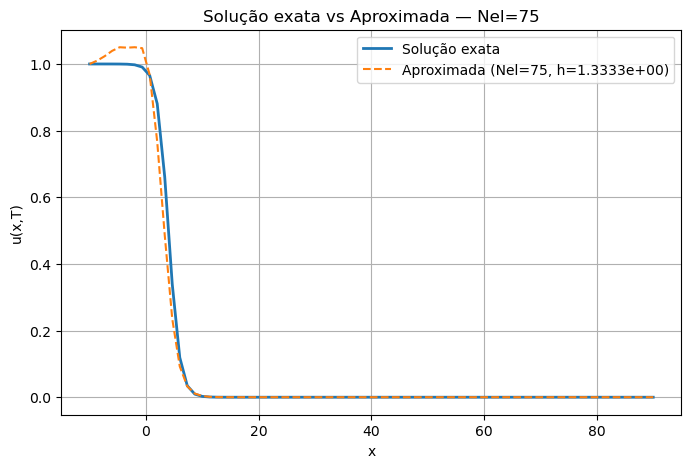

Executando solve_problemaA_problemaB com Nel = 150 ...


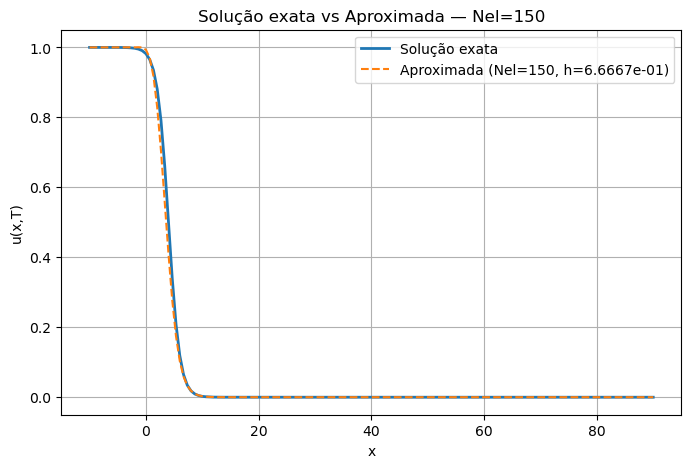

Executando solve_problemaA_problemaB com Nel = 500 ...


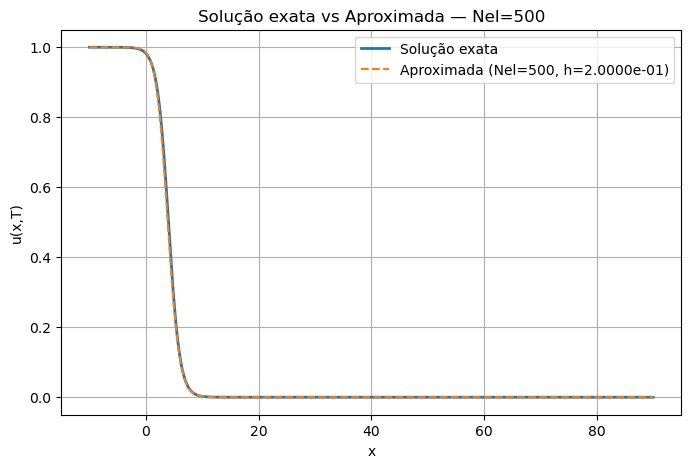


=== Estudo de Convergência (Problema A+B), Δt = h ===
Nel=   500, h=2.00e-01, dt=2.00e-01 -> Erro_inf = 3.535854e-02
Nel=  1000, h=1.00e-01, dt=1.00e-01 -> Erro_inf = 1.826083e-02
Nel=  2000, h=5.00e-02, dt=5.00e-02 -> Erro_inf = 9.284510e-03
Nel=  4000, h=2.50e-02, dt=2.50e-02 -> Erro_inf = 4.680888e-03
Nel=  8000, h=1.25e-02, dt=1.25e-02 -> Erro_inf = 2.350120e-03

=== Recalculando Exercício 1 (BackEuler atrasado) para comparação (Δt = h) ===
N= 500, h=2.00e-01, dt=2.00e-01 => Erro Inf = 5.0055e-02
N=1000, h=1.00e-01, dt=1.00e-01 => Erro Inf = 2.5693e-02
N=2000, h=5.00e-02, dt=5.00e-02 => Erro Inf = 1.3015e-02
N=4000, h=2.50e-02, dt=2.50e-02 => Erro Inf = 6.5512e-03
N=8000, h=1.25e-02, dt=1.25e-02 => Erro Inf = 3.2864e-03


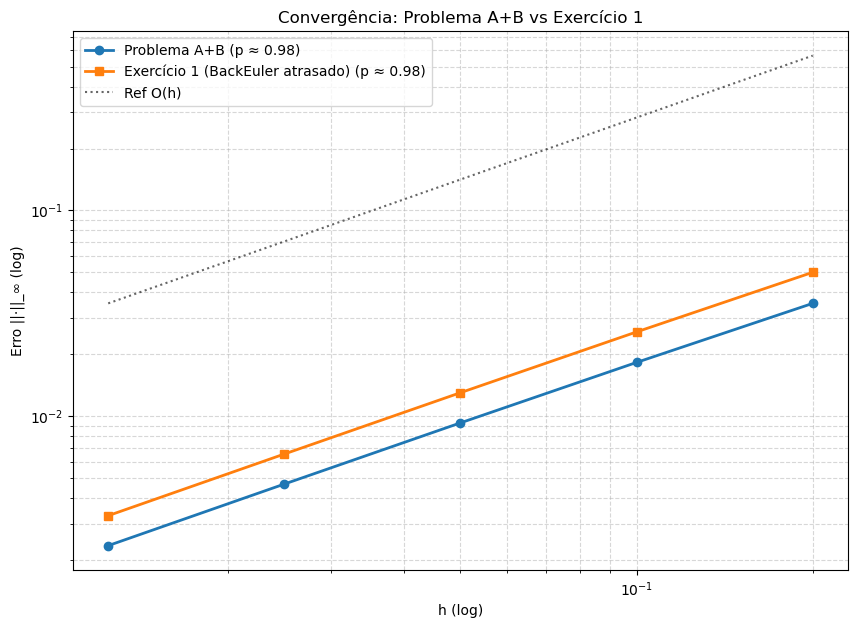


Tabela de erros — Problema A+B (Δt = h)
       N |            h |     erro_inf
-----------------------------------------
     500 | 2.000000e-01 | 3.535854e-02
    1000 | 1.000000e-01 | 1.826083e-02
    2000 | 5.000000e-02 | 9.284510e-03
    4000 | 2.500000e-02 | 4.680888e-03
    8000 | 1.250000e-02 | 2.350120e-03


Tabela de erros — Exercício 1 - BackEuler atrasado (Δt = h)
       N |            h |     erro_inf
-----------------------------------------
     500 | 2.000000e-01 | 5.005529e-02
    1000 | 1.000000e-01 | 2.569322e-02
    2000 | 5.000000e-02 | 1.301506e-02
    4000 | 2.500000e-02 | 6.551178e-03
    8000 | 1.250000e-02 | 3.286412e-03



(array([0.2   , 0.1   , 0.05  , 0.025 , 0.0125]),
 array([0.03535854, 0.01826083, 0.00928451, 0.00468089, 0.00235012]),
 array([0.2   , 0.1   , 0.05  , 0.025 , 0.0125]),
 array([0.05005529, 0.02569322, 0.01301506, 0.00655118, 0.00328641]))

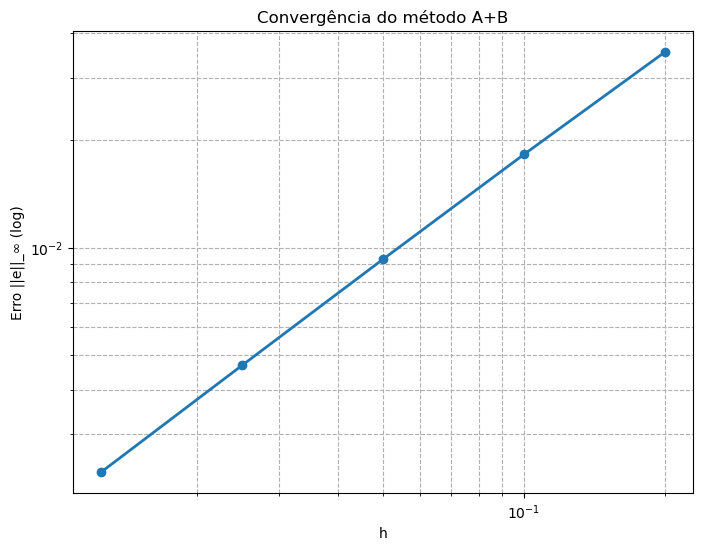

In [ ]:
def run_exercicio2_complete(a, b, T, delta):
    N_plot = [75, 150, 500]   
    plot_solucao_exata_vs_aproximada(N_plot, a, b, T, delta)

    N_list = [500, 1000, 2000, 4000, 8000]
    print("\n=== Estudo de Convergência (Problema A+B), Δt = h ===")
    h_AB, err_AB = convergence_study_problemaAB(N_list, a, b, T, delta)

    print("\n=== Recalculando Exercício 1 (BackEuler atrasado) para comparação (Δt = h) ===")
    h_ex1, err_ex1 = convergence_study(N_list, a, b, T, delta, dt_mode='h')  

    plot_compare_convergence_with_ex1(h_AB, err_AB, h_ex1, err_ex1)

    print_error_table(N_list, h_AB, err_AB, "Problema A+B (Δt = h)")
    print_error_table(N_list, h_ex1, err_ex1, "Exercício 1 - BackEuler atrasado (Δt = h)")

    plt.figure(figsize=(8,6))
    plt.loglog(h_AB, err_AB, 'o-', linewidth=2)
    plt.xlabel('h')
    plt.ylabel('Erro ||e||_∞ (log)')
    plt.title('Convergência do método A+B')
    plt.grid(True, which='both', linestyle='--')

    return (h_AB, err_AB, h_ex1, err_ex1)

a = -10.0
b =  90.0
T = 4.0
delta = 2.0
run_exercicio2_complete(a, b, T, delta)

# Questão 3

In [35]:
#   Condição inicial W-shape 
def w_shape(x):
    u = np.zeros_like(x)
    mask1 = (x >= 0.0) & (x <= 0.2)
    mask2 = (x > 0.2) & (x <= 0.4)
    mask3 = (x > 0.4) & (x <= 0.6)
    mask4 = (x > 0.6) & (x <= 0.8)
    u[mask1] = 1.0
    u[mask2] = 4.0*x[mask2] - 0.6
    u[mask3] = -4.0*x[mask3] + 2.6
    u[mask4] = 1.0
    return u

#   Solução exata
def exact_solution(x, T, kappa):
    return w_shape(x - kappa*T)

#   Thomas solver (tridiagonal)
def tridiag_solve(a, b, c, d):
    n = len(b)
    ac, bc, cc, dc = a.copy(), b.copy(), c.copy(), d.copy()
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

#   Métodos Numéricos
def ftcs_implicit_step(u, kappa, dt, h):
    alpha = kappa*dt/(2*h)
    n = len(u) - 2
    if n <= 0:
        return u.copy()

    a = np.full(n-1, -alpha)
    b = np.ones(n)
    c = np.full(n-1, alpha)

    rhs = u[1:-1].copy()
    rhs[0] -= a[0] * u[0]      
    u_int = tridiag_solve(a, b, c, rhs)

    u_new = u.copy()
    u_new[1:-1] = u_int
    return u_new

def upwind_explicit_step(u, kappa, dt, h):
    rho = kappa*dt/h
    u_new = u.copy()
    for j in range(1, len(u)-1):
        u_new[j] = u[j] - rho * (u[j] - u[j-1])
    return u_new

def lax_friedrichs_step(u, kappa, dt, h):
    rho = kappa*dt/h
    u_new = u.copy()
    for j in range(1, len(u)-1):
        u_new[j] = 0.5*(u[j-1] + u[j+1]) - 0.5*rho*(u[j+1] - u[j-1])
    return u_new


In [36]:
#   Função de Zoom
def plot_zoom(results, u_exact, zoom_min=0.35, zoom_max=0.65, T=0.25, dt=0, rho=0):
    plt.figure(figsize=(9,5))
    x = list(results.values())[0][0]
    idx = (x >= zoom_min) & (x <= zoom_max)

    plt.plot(x[idx], u_exact[idx], 'k-', linewidth=2, label="Solução Exata")

    for name, data in results.items():
        plt.plot(data[0][idx], data[1][idx], '--', label=name)

    plt.title(f"ZOOM região crítica — T={T}, Δt={dt:.4e}, ρ={rho:.3f}")
    plt.xlabel("x")
    plt.ylabel("u(x,T)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [37]:
#   Execução temporal
def run_scheme(scheme_step, a, b, N, kappa, T, dt):
    J = N + 1
    h = (b - a) / N
    x = np.linspace(a, b, J)
    u = w_shape(x)
    nsteps = int(np.ceil(T / dt))
    dt = T / nsteps

    for _ in range(nsteps):
        u = scheme_step(u, kappa, dt, h)
        u[0]  = 0.0   # u_L = 0
        u[-1] = 0.0   # u_R = 0

    return x, u



================ RESULTADOS (Erro L_inf) ================

Método               | Δt         | Erro L_inf      | ρ=Δt/h    
-----------------------------------------------------------------
FTCS Implícito       | 5.5000e-03 | 1.000000e+00 | 1.100
Upwind Explícito     | 5.5000e-03 | 1.816825e+02 | 1.100
Lax-Friedrichs       | 5.5000e-03 | 7.493040e+00 | 1.100


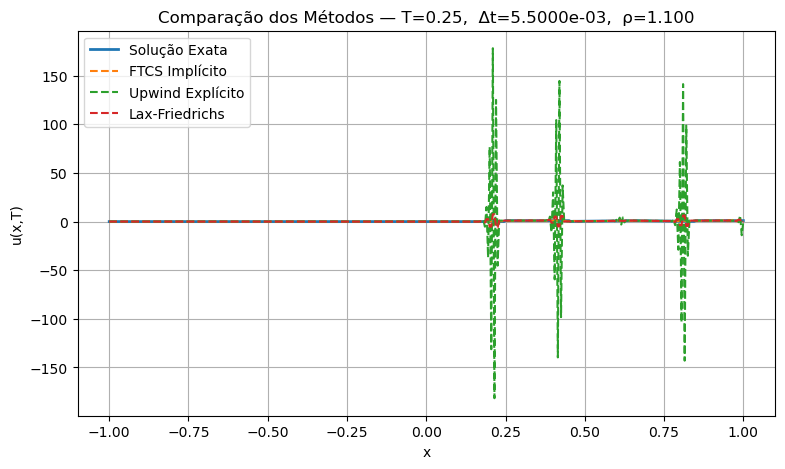

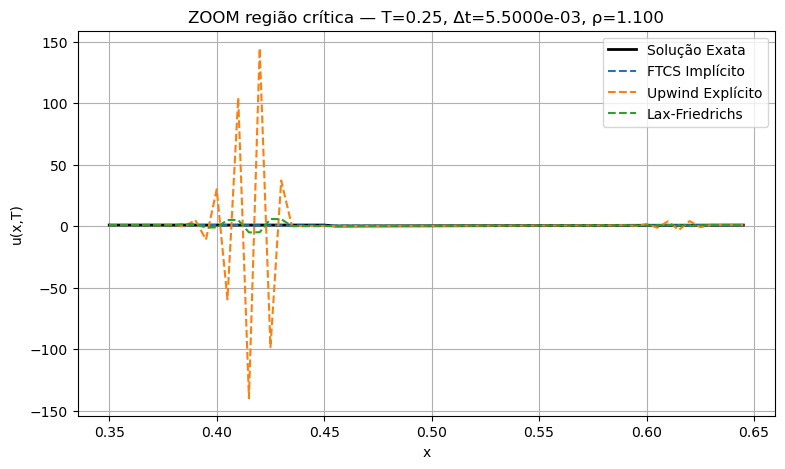

FTCS Implícito       | 2.5000e-03 | 1.000000e+00 | 0.500
Upwind Explícito     | 2.5000e-03 | 1.000000e+00 | 0.500
Lax-Friedrichs       | 2.5000e-03 | 1.000000e+00 | 0.500


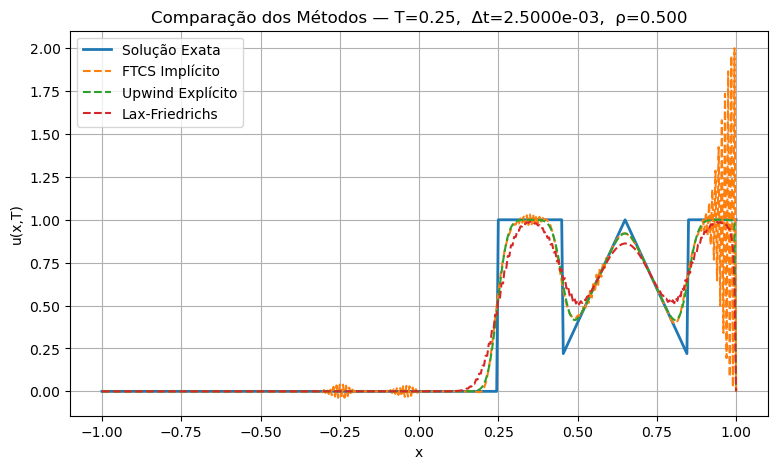

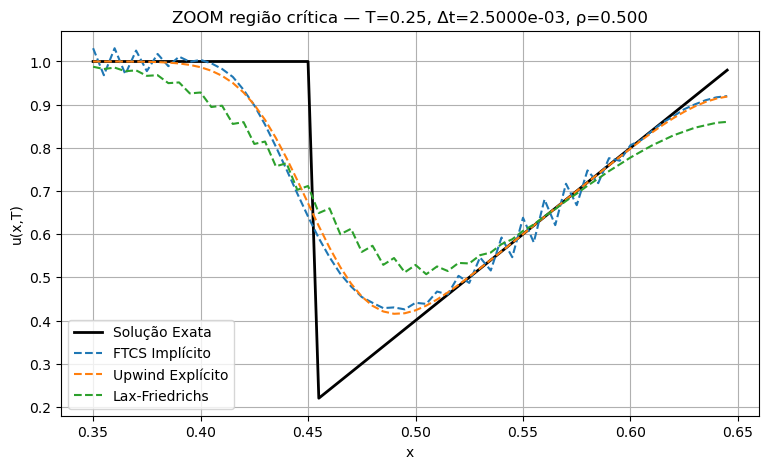

In [ ]:
#   Experimento completo
def experiment():
    a, b = -1.0, 1.0
    N = 400
    kappa = 1.0
    T = 0.25
    h = (b - a) / N

    dt_list = [1.1*h, 0.5*h]
    schemes = [
        ("FTCS Implícito", ftcs_implicit_step),
        ("Upwind Explícito", upwind_explicit_step),
        ("Lax-Friedrichs", lax_friedrichs_step)
    ]

    print("\n================ RESULTADOS (Erro L_inf) ================\n")
    print(f"{'Método':<20} | {'Δt':<10} | {'Erro L_inf':<15} | {'ρ=Δt/h':<10}")
    print("-"*65)

    for dt in dt_list:
        rho = kappa*dt/h
        results = {}

        for name, step in schemes:
            x, u_num = run_scheme(step, a, b, N, kappa, T, dt)
            u_ex = exact_solution(x, T, kappa)
            err = np.max(np.abs(u_num - u_ex))
            results[name] = (x, u_num, err)

            print(f"{name:<20} | {dt:.4e} | {err:.6e} | {rho:.3f}")

        plt.figure(figsize=(9,5))
        plt.plot(x, u_ex, label="Solução Exata", linewidth=2)
        for name in results:
            plt.plot(results[name][0], results[name][1], '--', label=name)
        plt.grid(True)
        plt.xlabel("x")
        plt.ylabel("u(x,T)")
        plt.title(f"Comparação dos Métodos — T={T},  Δt={dt:.4e},  ρ={rho:.3f}")
        plt.legend()
        plt.show()

        plot_zoom(results, u_ex, zoom_min=0.35, zoom_max=0.65, T=T, dt=dt, rho=rho)

# Rodar experimento
experiment()
